In [0]:
#add tfidf for keyword sample

In [2]:
!git clone https://github.com/zxzhaixiang/QMDB

Cloning into 'QMDB'...
remote: Enumerating objects: 13, done.
remote: Counting objects: 100% (13/13), done.
remote: Compressing objects: 100% (13/13), done.
remote: Total 597 (delta 6), reused 0 (delta 0), pack-reused 584
Receiving objects: 100% (597/597), 269.38 MiB | 39.74 MiB/s, done.
Resolving deltas: 100% (334/334), done.
Checking out files: 100% (101/101), done.


In [0]:
datapath = './QMDB/data/processed_data/'
#datapath = './../data/processed_data/'

In [5]:
!pip install hiddenlayer

In [6]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
savepath = './gdrive/My Drive/'

In [8]:
import os
import numpy as np
import matplotlib.pyplot as plt
import time
import sys
import pickle
import random
import scipy.signal as sp_signal
import pandas as pd
import seaborn as sns
from datetime import datetime
import re

from imblearn.over_sampling import RandomOverSampler

from sklearn import decomposition
from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction.text import TfidfVectorizer
from scipy.sparse import csr_matrix

from sklearn.manifold import TSNE
import scipy.stats

from IPython.display import HTML, display

import hiddenlayer as hl
%matplotlib inline

/usr/local/lib/python3.6/dist-packages/sklearn/externals/six.py:31: DeprecationWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", DeprecationWarning)


In [0]:
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader, TensorDataset
from torch.utils.data.sampler import SubsetRandomSampler, WeightedRandomSampler
from torch.autograd import Variable
from torchvision import transforms

In [10]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Device is ", device)

Device is  cuda


In [11]:
torch.__version__

'1.1.0'

In [0]:
model_save_name='cfmodel_v05'

## Loading data and prepare data loader

In [13]:
print('loading raw rating data..',end='')
rating_df = pd.read_csv(os.path.join(datapath,'ratings_with_kws.csv'), compression='gzip')

#print('Done\n {} total rating record loaded\n'.format(rating_df.shape[0]))

userIds = rating_df['userId'].unique()

loading raw rating data..

In [0]:
user_df = rating_df.groupby('userId', as_index=False).agg({
                      'movieId': [('num_movie_rated','count')],
                      'rating': [('user_ave_rating','mean'),('user_std_rating','std')]}).fillna(0)
user_df.columns.set_levels([item if item!='' else 'userId' for item in user_df.columns.levels[1]],level=1,inplace=True)
user_df.columns = user_df.columns.droplevel(0) #drop first level column name (old column name before aggregation)

In [0]:
rating_by_movie_df = rating_df.groupby('movieId', as_index = False).agg({
                    'userId': [('num_rating', 'count')],
                    'rating': [('movie_ave_rating','mean'),('movie_std_rating', 'std')]})
rating_by_movie_df.columns.set_levels([item if item!='' else 'movieId' for item in rating_by_movie_df.columns.levels[1]],level=1,inplace=True)
rating_by_movie_df.columns = rating_by_movie_df.columns.droplevel(0)#drop first level column name (old column name before aggregation)       

In [0]:
movie_df = pd.read_csv(os.path.join(datapath,'keywords_all.csv'))
movie_df = movie_df.merge(rating_by_movie_df, how='left',on='movieId').reset_index()
#movie_df.drop(columns='genres',inplace=True)
movie_df['genre_kws'] = movie_df['genre_kws'].apply(lambda s: re.sub(r'\[|\]|\'| ', '', s).lower()) 
#movie_df['description_kws'] = movie_df['description_kws'].apply(lambda s: re.sub(r'\[|\]|\'| |"', '', s).lower()) 
#movie_df['cast_kws'] = movie_df['cast_kws'].apply(lambda s: re.sub(r'\[|\]|\'| ', '', s)) 

#genres = {a for s in movie_df['genres'] for a in s.split('|')}
#print('{} number of movie genres exist. They are '.format(len(genres)), genres)
#genres_dict = dict(zip(genres, range(len(genres))))

In [0]:
tmp_movie_df = pd.read_csv(os.path.join(datapath, 'movies_with_kws.csv'))
tmp_movie_df['title_kws'] = tmp_movie_df['title'].apply(lambda x: re.sub(r'\(|\)|,|\.|\'',' ',x.lower()))
#tmp_movie_df['title_kws'] = tmp_movie_df['title_kws'].apply(lambda x: re.sub(r'\'',' ',x.lower()))

tmp_movie_df['cast_kws'] = tmp_movie_df['cast_kws'].apply(lambda x: ' '.join(eval(x.lower())))
tmp_movie_df['title_cast_kws'] = tmp_movie_df['cast_kws'] + ' '+ tmp_movie_df['title_kws'] + ' ' + tmp_movie_df['title_kws'] + ' ' + tmp_movie_df['title_kws']

tmp_movie_df.drop(columns=['title','cast_kws','title_kws', 'movieId','genres','tmdbId','imdbId','year','genre_kws','description_kws','imgUrl'], inplace=True)

In [0]:
movie_df = movie_df.merge(tmp_movie_df, on='qmdbId')
movie_df['kws_all'] = movie_df['kws_all'] + ' ' + movie_df['title_cast_kws'] + ' ' + movie_df['title_cast_kws'] + ' ' + movie_df['title_cast_kws'] + ' ' + movie_df['title_cast_kws']

In [19]:
#genres_list = {a.lower() for s in movie_df['genre_kws'] for a in s.split(',')}
#genres_list = list(genres_list)
genres_list = ['tv', 'movie', 'fantasy', 'documentary', 'comedy', 'drama', 'mystery', 'horror', 'science', 'family', 'crime', 'history', 'action', 'adventure', 'fiction', 'music', 'war', 'animation', 'western', 'thriller', 'foreign', 'romance']
print('{} number of movie genres exist. They are '.format(len(genres_list)), genres_list)
genres_dict = dict(zip(genres_list, range(len(genres_list))))

22 number of movie genres exist. They are  ['tv', 'movie', 'fantasy', 'documentary', 'comedy', 'drama', 'mystery', 'horror', 'science', 'family', 'crime', 'history', 'action', 'adventure', 'fiction', 'music', 'war', 'animation', 'western', 'thriller', 'foreign', 'romance']


In [0]:
genres = np.zeros((movie_df.shape[0], len(genres_list)))
for irow, s in enumerate(movie_df['genre_kws']):
    for j in [genres_dict[e] for e in s.split(',')]:
        genres[irow,j]=1

### keywords

In [0]:
with open(os.path.join(datapath,'keyword_embedding.pkl'), 'rb') as f:
    kw_embedding_np = pickle.load(f)

In [0]:
kw_embedding = dict()
kw_default_embedding = torch.zeros(1,1,64)
n=0
for key in kw_embedding_np:
    kw_embedding[key] = torch.FloatTensor(kw_embedding_np[key]).unsqueeze(dim=0).unsqueeze(dim=0)
    kw_default_embedding += kw_embedding[key]
    n+=1

kw_default_embedding/=n

In [0]:
kw_set = set(kw_embedding.keys())

In [24]:
len(kw_set)

21403

In [0]:
corpus  = [kws for kws in movie_df['kws_all']]
vectorizer = TfidfVectorizer(max_df=0.1, min_df=0.0003)
X = vectorizer.fit_transform(corpus)

In [0]:
words = vectorizer.get_feature_names()
Tfidf_indmap = dict(zip(words, range(len(words))))

In [0]:
kw_by_movie = [[words[j] for j in X_row.nonzero()[1]] for X_row in X]
kw_relevance_by_movie = [np.array([float(X_row[0,j]) for j in X_row.nonzero()[1]]) for X_row in X]
kw_relevance_by_movie = [r/r.sum() for r in kw_relevance_by_movie]

In [0]:
movie_default_kw_embedding_np = np.array([np.average(np.stack([kw_embedding_np[kw] for kw in kws], axis=0),axis=0, weights = kw_imps) for kws, kw_imps in zip(kw_by_movie,kw_relevance_by_movie)])
movie_default_kw_embedding = torch.FloatTensor(movie_default_kw_embedding_np)

In [29]:
TopMovies_id = movie_df['num_rating'].nlargest(200).index.values
Movie_Em = movie_default_kw_embedding_np/np.linalg.norm(movie_default_kw_embedding_np,axis=1, keepdims=True)
Movie_S = np.matmul(Movie_Em, Movie_Em.T)
for i in range(50):
    movie_id = TopMovies_id[i]
    t = movie_df['title'][movie_id]
    print('Movie:'+t)
    
    tmp_S = Movie_S[movie_id]
    tmp_ids = tmp_S.argsort()[::-1]
    n = 0
    for tmp_id in tmp_ids[1:]:
        if(movie_df['movie_ave_rating'][tmp_id]>0.0):
            t = movie_df['title'][tmp_id]
            print('  ',t)
            n+=1
        if (n>10):
            break
    print()

Movie:Matrix, The
   Matrix Revolutions, The
   Matrix Reloaded, The
   Ex Machina
   Avatar
   Memento
   Prometheus
   Star Wars: Episode IV - A New Hope
   Moon
   Interstellar
   Blade Runner
   Dark City

Movie:Forrest Gump
   Up
   Inside Out
   Donnie Darko
   Big Hero 6
   Inception
   Schindler's List
   Serenity
   It's a Wonderful Life
   Looper
   Unbreakable
   Memento

Movie:Back to the Future
   Back to the Future Part II
   Back to the Future Part III
   Big Year, The
   Up
   Place Beyond the Pines, The
   Big
   Green Lantern
   Big Hero 6
   Cast Away
   Unbreakable
   Inside Out

Movie:Pulp Fiction
   Fight Club
   Matrix, The
   Shawshank Redemption, The
   Fifth Element, The
   Being John Malkovich
   Mulholland Drive
   Memento
   Casablanca
   Watchmen
   Schindler's List
   Stranger than Fiction

Movie:Jurassic Park
   Lost World: Jurassic Park, The
   Jurassic World
   Jurassic Park III
   Monsters
   The Good Dinosaur
   Thing, The
   NeverEnding Story, The
 

### prepare data

In [0]:
nM      = movie_df.shape[0]
nU      = user_df.shape[0]
nR      = rating_df['rating'].unique().shape[0]
nRecord = rating_df['rating'].shape[0]

In [0]:
U    = torch.tensor(rating_df['userId'].values,  dtype=torch.long).reshape(-1,1)
M    = torch.tensor(rating_df['qmdbId'].values, dtype=torch.long).reshape(-1,1)
R    = torch.tensor(rating_df['rating'].values, dtype=torch.float).reshape(-1,1)/5
#G    = torch.tensor(genres, dtype=torch.float)
#Qkw  = movie_default_kw_embedding

In [0]:
batch_size = 4096
validation_split = .2
shuffle_dataset = True
random_seed = 42

In [0]:
dataset_size = nRecord
indices = list(range(dataset_size))
split = int(np.floor(validation_split * dataset_size))
if shuffle_dataset :
    np.random.seed(random_seed)
    np.random.shuffle(indices)
train_idx, val_idx = indices[split:], indices[:split]

In [0]:
ros = RandomOverSampler(random_state=random_seed)
train_idx_resampled, _ = ros.fit_resample(np.array(train_idx).reshape(-1,1), (R[train_idx].numpy()*10).reshape(-1).astype(int))
train_idx_resampled = list(train_idx_resampled.reshape(-1))

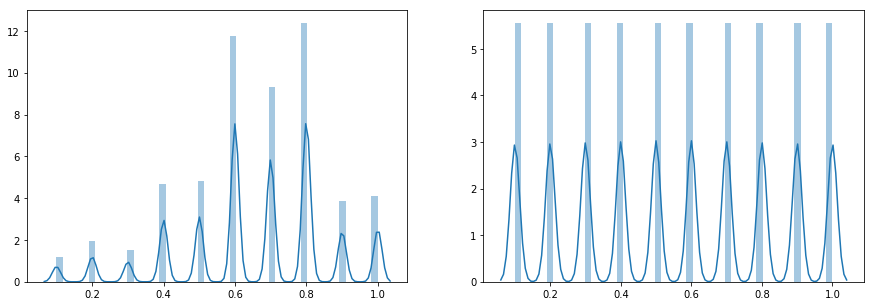

In [36]:
plt.figure(figsize=(15,5))
plt.subplot(121)
sns.distplot(R[train_idx])
plt.subplot(122)
sns.distplot(R[train_idx_resampled])

In [0]:
ind = train_idx
#ind = train_idx_resampled

train_dataset = torch.utils.data.TensorDataset(
    U[ind], M[ind], R[ind])

train_loader = DataLoader(
    train_dataset, batch_size=batch_size, shuffle = True)

In [0]:
ind = val_idx
val_dataset = torch.utils.data.TensorDataset(
    U[ind], M[ind], R[ind])
val_loader = DataLoader(
    val_dataset, batch_size=batch_size, shuffle = True)

## Build model

In [0]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

In [0]:
class NCF(nn.Module):
    def __init__(self, config):
        super(NCF, self).__init__()
        self.config = config
        self.user_dim = config['nUsers']
        self.movie_dim = config['nMovies']
        self.genres_dim = config['nGenres']
        
        self.g_latent_dim = config['genre_latent_dim']
        self.u_latent_dim = config['user_latent_dim']
        self.i_latent_dim = config['item_latent_dim']
        
        self.user_embedding = nn.Embedding(self.user_dim, self.u_latent_dim, 
                                           max_norm=1, scale_grad_by_freq = True)
        
        self.movie_embedding = nn.Embedding(self.movie_dim, self.i_latent_dim,
                                           max_norm=1, scale_grad_by_freq = True)

#        self.genre_embedding = nn.Embedding(self.genres_dim, self.g_latent_dim,
#                                           max_norm=1, scale_grad_by_freq = True)

        
        self.fc_layers_relevance = nn.Sequential(
            nn.Linear(self.i_latent_dim + 64, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 1),
            nn.Sigmoid()
        )
        
#        self.cos_sim = nn.CosineSimilarity(dim=2, eps=1e-6)
        
    def forward(self, user_id, movie_id, em_query):
        user_em = self.user_embedding(user_id)
        movie_em = self.movie_embedding(movie_id)
        #genres_em = self.genres_layers(genres)
        
        final_query_em = user_em + em_query
        
        relevance_em = torch.cat((movie_em, em_query), dim=2)
        relevance_em = relevance_em.view(-1, self.i_latent_dim + 64)

        relevance_score = self.fc_layers_relevance(relevance_em)

        return relevance_score.view(-1,1), torch.bmm(final_query_em, movie_em.view(-1,self.i_latent_dim, 1)).view(-1,1)

In [41]:
config = {'nUsers': nU, 'nMovies': nM, 
          'nGenres': len(genres_list),
          'user_latent_dim': 64, 'item_latent_dim': 64,
          'genre_latent_dim': 64
         }
print(config)


{'nUsers': 4380, 'nMovies': 3868, 'nGenres': 22, 'user_latent_dim': 64, 'item_latent_dim': 64, 'genre_latent_dim': 64}


In [0]:
CF = NCF(config).to(device)

In [0]:
CF_criterion = nn.MSELoss()
CF_relevance_criterion = nn.BCELoss()

CF_optimizer = torch.optim.Adam(CF.parameters(), lr = 0.001, betas = (0.5, 0.999))

In [44]:
count_parameters(CF)

552705

/usr/local/lib/python3.6/dist-packages/torch/onnx/utils.py:586: UserWarning: ONNX export failed on ATen operator embedding_renorm because torch.onnx.symbolic.embedding_renorm does not exist
  .format(op_name, op_name))


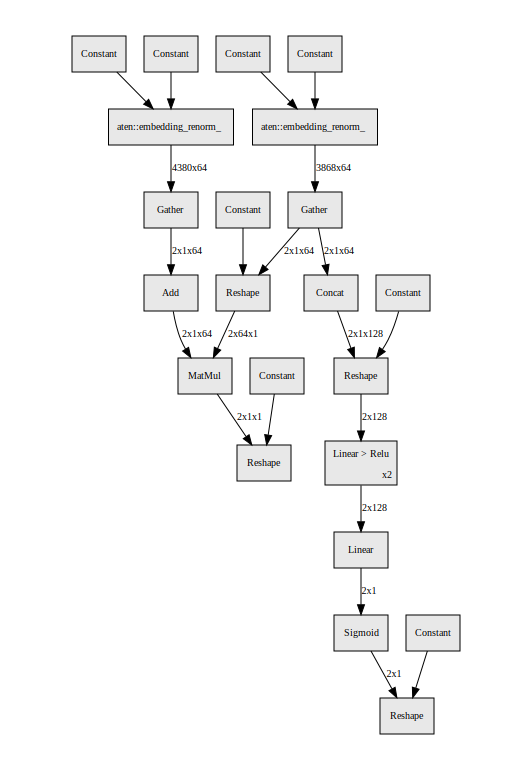

In [45]:
hl.build_graph(CF, (torch.LongTensor(np.zeros((2,1))).to(device), #uids
   torch.LongTensor(np.zeros((2,1))).to(device), #mids
   torch.FloatTensor(np.zeros((2,1,64))).to(device)#query
   )) #hr


In [46]:
CF(torch.LongTensor(np.zeros((2,1))).to(device), #uids
   torch.LongTensor(np.zeros((2,1))).to(device), #mids
   torch.FloatTensor(np.zeros((2,1,64))).to(device)#query
   ) #hr


(tensor([[0.5216],
         [0.5216]], device='cuda:0', grad_fn=<ViewBackward>), tensor([[0.1518],
         [0.1518]], device='cuda:0', grad_fn=<ViewBackward>))

## Training

In [0]:
class progress():
    def __init__(self,max = 100):
        self.mrange = max
        self.pbar = display(self.progress(0,M=self.mrange, loss_score=0, loss_relevance=0), display_id = True)

    def update(self, i, loss_score=0, loss_relevance=0):
        self.pbar.update(self.progress(i,M=self.mrange, loss_score=loss_score, loss_relevance=loss_relevance))
    
    def progress(self, value, loss_score=0, loss_relevance=0, M=100):
        return HTML("""Training Mini Batch [{value}/{M}] Loss [rating={loss_score:0.5f}, relevance={loss_relevance:0.5f}] <progress
                value='{value}'
                max='{M}',
                style='width: 80%'
            >
                90
            </progress>
              """.format(value=value, M=M, loss_score=loss_score, loss_relevance=loss_relevance))

In [48]:
nBatch_train = train_loader.__len__()
nBatch_val = val_loader.__len__()

print('{} mini-batches in training dataset, {} mini-batches in validation dataset'.format(nBatch_train, nBatch_val))

657 mini-batches in training dataset, 165 mini-batches in validation dataset


In [0]:
epoch_num = 50

In [0]:
def lr_schedular(optimizer, epoch):
    if(epoch<2):
        lr = 0.001
    elif(epoch<10):
        lr = 0.0006
    elif (epoch<20):
        lr = 0.0004
    else:
        lr = 0.0002

    for param_group in optimizer.param_groups:
        param_group['lr']=lr

    return optimizer

In [0]:
def get_irrelevant_movies(movies):
    res = np.random.choice(nM, movies.shape[0], replace=True)
    return torch.LongTensor(res).view(movies.shape)

In [0]:
def get_query_tensor(movieIds):
    
    def get_embedding(kw_list):
        if len(kw_list)==0:
            return kw_default_embedding
        else:
            res = torch.zeros(kw_default_embedding.shape)
            for kw in kw_list:
#                if kw in kw_set:
                res+=kw_embedding[kw]
            return res/len(kw_list)

    res = []
    for i in movieIds.detach().cpu().numpy().flatten():
        n_kw = len(kw_by_movie[i])
        kws = random.choices(kw_by_movie[i], weights = kw_relevance_by_movie[i], k = random.randint(3,8))
        res.append(get_embedding(kws))

    return torch.cat(res,dim=0).to(device)

In [0]:
train_losses = []
train_rating_losses = []
train_relevance_losses = []

val_losses = []
val_rating_losses = []
val_relevance_losses = []

In [78]:
CF.load_state_dict(torch.load(os.path.join(savepath, model_save_name)))


IncompatibleKeys(missing_keys=[], unexpected_keys=[])

In [1]:
for epoch in range(epoch_num):
    
    print('Training epoch {}/{}'.format(epoch, epoch_num))
    pbar = progress(train_loader.__len__())
    
    CF_optimizer = lr_schedular(CF_optimizer, epoch)

    CF.train()
    
    tmp_loss_rating = 0
    tmp_loss_relevance = 0
    
    for i,(users, movies, ratings) in enumerate(train_loader):
        if i%5==0:
            pbar.update(i+1, tmp_loss_rating, tmp_loss_relevance)

        U, I, R = users.to(device), movies.to(device), ratings.to(device)
        irrelevant_movies = get_irrelevant_movies(movies)
        #Q = get_query_tensor(movies)
        #Q_irrelevant = get_query_tensor(irrelevant_movie)
        Q = get_query_tensor(movies)
        Q_irrelevant = get_query_tensor(irrelevant_movies)

        rel_score, rhat = CF(U, I, Q)
        irrel_score, _ = CF(U, I, Q_irrelevant)
        
        loss_rating = CF_criterion(rhat, R)
        
        loss_relevance = CF_relevance_criterion(irrel_score, 0.1*torch.ones(irrel_score.shape).to(device)) + \
                        CF_relevance_criterion(rel_score, 0.9*torch.ones(rel_score.shape).to(device))
                         
        loss = 5*loss_rating + loss_relevance
        
        CF_optimizer.zero_grad()
        
        loss.backward()
        
        CF_optimizer.step()
        
        train_losses.append(loss.item())
        train_rating_losses.append(loss_rating.item())
        train_relevance_losses.append(loss_relevance.item())
        
        tmp_loss_rating = loss_rating.item()
        tmp_loss_relevance = loss_relevance.item()        
    
    CF.eval()

    torch.save(CF.state_dict(), os.path.join(savepath,model_save_name))
    torch.save(CF.state_dict(), './'+model_save_name)

    for i, (users, movies, ratings) in enumerate(val_loader):
        U, I, R = users.to(device), movies.to(device), ratings.to(device)
        irrelevant_movies = get_irrelevant_movies(movies)
        Q = get_query_tensor(movies)
        Q_irrelevant = get_query_tensor(irrelevant_movies)

        rel_score, rhat = CF(U, I, Q)
        irrel_score, _ = CF(U, I, Q_irrelevant)
        
        loss_rating = CF_criterion(rhat, R)
        
        loss_relevance = CF_relevance_criterion(irrel_score, 0.1*torch.ones(rel_score.shape).to(device)) + \
                        CF_relevance_criterion(rel_score, 0.9*torch.ones(rel_score.shape).to(device))
                         
        loss = 5*loss_rating + loss_relevance
        
        val_losses.append(loss.item())
        val_rating_losses.append(loss_rating.item())
        val_relevance_losses.append(loss_relevance.item())
    
    print('epoch[{}/{}], train loss = {:.4f}=5x{:.4f}(rating) + {:.4f}(relevance), val loss = {:.4f}=5x{:.4f}(rating)+{:.4f}(relevance)'.
         format(epoch, epoch_num, train_losses[-1], train_rating_losses[-1], train_relevance_losses[-1], val_losses[-1], val_rating_losses[-1], val_relevance_losses[-1]))
    
    if (epoch%1==0):
        plt.figure(figsize=(15,5))
        plt.subplot(121)
        plt.plot(train_losses, label='train loss')
        plt.xlabel('# batch'), plt.ylabel('loss'), plt.legend(), plt.yscale('log')
        plt.subplot(122)
        plt.plot(val_losses, label='val loss')
        plt.xlabel('# batch'), plt.ylabel('loss'), plt.legend(), plt.yscale('log')
        plt.show()

NameError: ignored

In [0]:
CF.eval()

torch.save(CF.state_dict(), os.path.join(savepath,model_save_name))
torch.save(CF.state_dict(), './'+model_save_name)


NameError: ignored

In [0]:
Movie_Em = CF.movie_embedding.weight.data.detach().cpu().numpy()
User_Em = CF.user_embedding.weight.data.detach().cpu().numpy()

In [0]:
ave_User_Em = User_Em.mean(axis=0, keepdims=True)

In [0]:
with open('./movie_embedding', 'wb') as f:
    pickle.dump(Movie_Em, f)
with open('./ave_user_embedding', 'wb') as f:
    pickle.dump(ave_User_Em, f)


In [58]:
plt.figure(figsize=(18,6))

plt.plot(np.linspace(0,epoch+1, len(train_losses)),train_losses,label='train_loss')
plt.plot(np.linspace(0,epoch+1, len(train_rating_losses)),train_rating_losses,label='train_loss(rating)')
plt.plot(np.linspace(0,epoch+1, len(train_relevance_losses)),train_relevance_losses,label='train_loss(relevance)')
plt.plot(np.linspace(0,epoch+1, len(val_losses)),val_losses,label='val_loss')
plt.plot(np.linspace(0,epoch+1, len(val_rating_losses)),val_rating_losses,label='val_rating_loss')
plt.plot(np.linspace(0,epoch+1, len(val_relevance_losses)),val_relevance_losses,label='val_relevance_loss')
plt.yscale('log')
plt.legend(),plt.xlabel('epoch'), plt.ylabel('loss')
plt.grid(True)
#plt.ylim([0.01,0.05])

NameError: ignored

<Figure size 1296x432 with 0 Axes>

In [60]:
r_real = []
r_pred = []

n_tp = 0
n_tn = 0
n_fp = 0
n_fn = 0


with torch.no_grad():
    for i, (users, movies, ratings) in enumerate(val_loader):
        U, I, R = users.to(device), movies.to(device), ratings.to(device)
        irrelevant_movies = get_irrelevant_movies(movies)
        Q = get_query_tensor(movies)
        Q_irrelevant = get_query_tensor(irrelevant_movies)

        rel_score, rhat = CF(U, I, Q)
        irrel_score, _ = CF(U, I, Q_irrelevant)

        r_real+=list(R.detach().cpu().numpy().reshape(-1))
        r_pred+=list(rhat.detach().cpu().numpy().reshape(-1))
        
        rel_score = rel_score.detach().cpu().numpy().flatten()
        irrel_score = irrel_score.detach().cpu().numpy().flatten()
        
        n_tp += np.sum(rel_score>0.5)
        n_tn += np.sum(irrel_score<0.5)
        n_fp += np.sum(irrel_score>0.5)
        n_fn += np.sum(rel_score<0.5)
        
        if(i%20==0):
            print('{}/{}'.format(i,nBatch_val))

0/165
20/165
40/165
60/165
80/165
100/165
120/165
140/165
160/165


In [61]:
print('           | predict relevant  |  predict irrelevant')
print('relevant   |   %5d           |     %5d          ' % (n_tp, n_fn))
print('irrelevant |   %5d           |     %5d          ' % (n_fp, n_tn))

precision = n_tp/(n_tp+n_fp)
recall = n_tp/(n_tp+n_fn)
print('precision = %f' % precision)
print('recall = %f' % recall)

print('F1-score = %f' % (2/(1/precision+1/recall)))

           | predict relevant  |  predict irrelevant
relevant   |   589711           |     82103          
irrelevant |   58537           |     613277          
precision = 0.909700
recall = 0.877789
F1-score = 0.893460


In [0]:
r_real = np.array(r_real) #, dtype=np.int)
r_pred = np.array(r_pred) #, dtype=np.int)
e = r_pred - r_real

In [0]:
r_pearson = scipy.stats.pearsonr(r_real, r_pred)[0]
r_spearman = scipy.stats.spearmanr(r_real, r_pred).correlation
slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(r_real, r_pred)

In [64]:
print('average error = {}, std = {}'.format(e.mean(), e.std()))
print('mae = {}'.format(np.abs(e).mean()))
print('rmse = {}'.format(np.sqrt(np.square(e).mean())))

print('slope={}, r2={}'.format(slope, r_value))
print('pearson = {}, spearman = {}'.format(r_pearson, r_spearman))

average error = -0.07256198674440384, std = 0.21361713111400604
mae = 0.17824974656105042
rmse = 0.22560475766658783
slope=0.45226508081642997, r2=0.46226431580140875
pearson = 0.4622643158014077, spearman = 0.4543874182969224


(Text(0.5, 0, 'predict error'), Text(0, 0.5, 'count'))

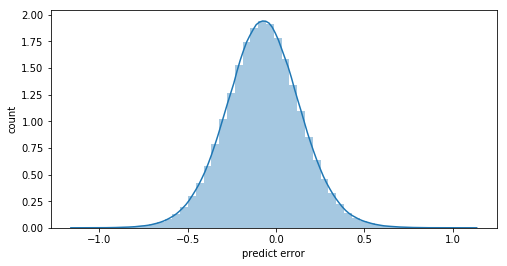

In [65]:
plt.figure(figsize=(8,4))
sns.distplot(r_pred-r_real, kde=True)
plt.xlabel('predict error'), plt.ylabel('count')

In [0]:
real = R.view(-1).detach().cpu().numpy()
pred = rhat.view(-1).detach().cpu().numpy()
users = U.detach().cpu().numpy().reshape(-1)
movies = I.detach().cpu().numpy().reshape(-1)
pd_df = pd.DataFrame({'real': real,'pred':pred, 'userId': users, 'movieId': movies})
pd_df = pd_df.merge(movie_df, how='left', on='movieId')
pd_df = pd_df.merge(user_df, how='left', on='userId')
#pd_df = pd_df.drop(columns = ML_Data.movie_genres)

In [68]:
pd_df.head(50)

,real,pred,userId,movieId,index,Unnamed: 0,title,qmdbId,tmdbId,year,genre_kws,kws_all,num_rating,movie_ave_rating,movie_std_rating,title_cast_kws,num_movie_rated,user_ave_rating,user_std_rating
0,0.6,0.539580,1037,82,33.0,33.0,Vampire in Brooklyn,33.0,12158.0,1995.0,"comedy,romance,horror",vampires clv bassett craven in angela payne ed...,527.0,2.074953,0.915944,eddie allen payne bassett murphy angela wes cr...,1712,2.605140,0.695260
1,0.7,0.616307,3818,532,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1104,3.001812,0.804282
2,0.6,0.715526,3010,3094,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1279,3.132525,0.927238
3,0.3,0.323292,4221,63,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,844,3.459716,0.847248
4,0.8,0.535910,653,3723,1261.0,1261.0,America's Sweethearts,1261.0,11467.0,2001.0,"comedy,romance",joe sweethearts julia zeta jones business r se...,1157.0,2.689283,0.958727,crystal catherine zeta-jones roberts julia bil...,621,3.981481,0.469277
5,0.9,0.917396,4076,81,32.0,32.0,Mary Reilly,32.0,9095.0,1996.0,"thriller,romance,drama,horror",cole and malkovich george hyde frears servant ...,443.0,2.495485,0.948911,john george roberts malkovich julia cole steph...,2330,3.132189,0.848757
6,0.9,0.564404,2619,3082,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1004,3.653884,0.879293
7,0.6,0.534915,3599,70,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,697,2.684362,0.943489
8,0.2,0.178956,1471,556,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,691,3.471056,1.030633
9,0.4,0.456749,3526,532,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,825,2.859394,0.976787


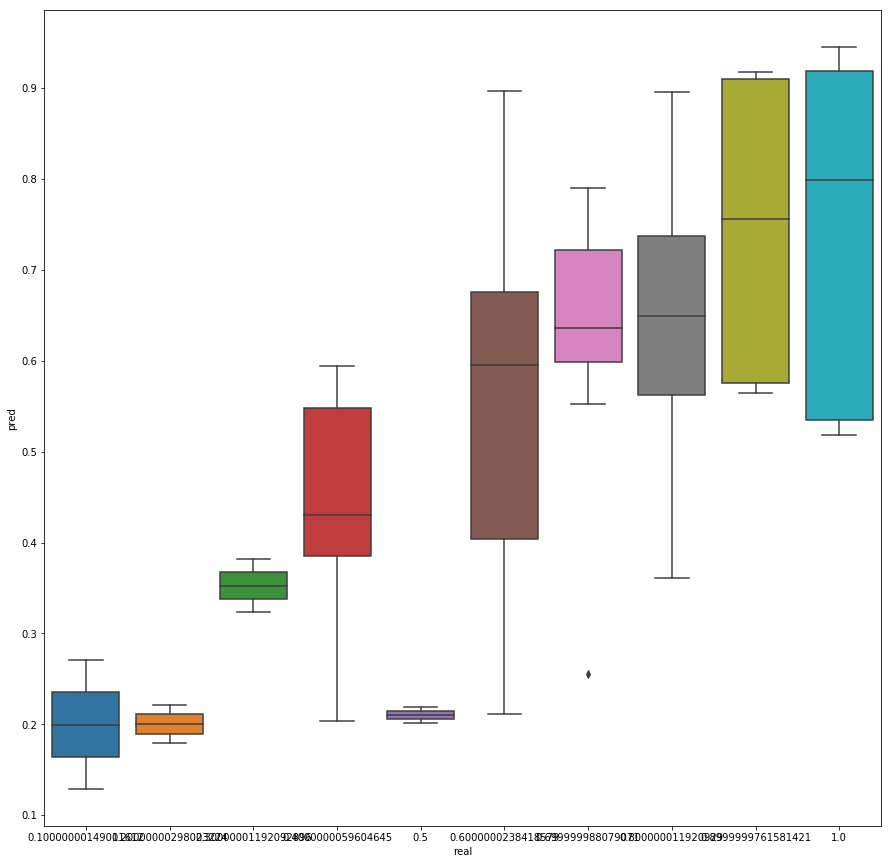

In [69]:
plt.figure(figsize=(15,15))
sns.categorical.boxplot(x="real", y="pred", data=pd_df)

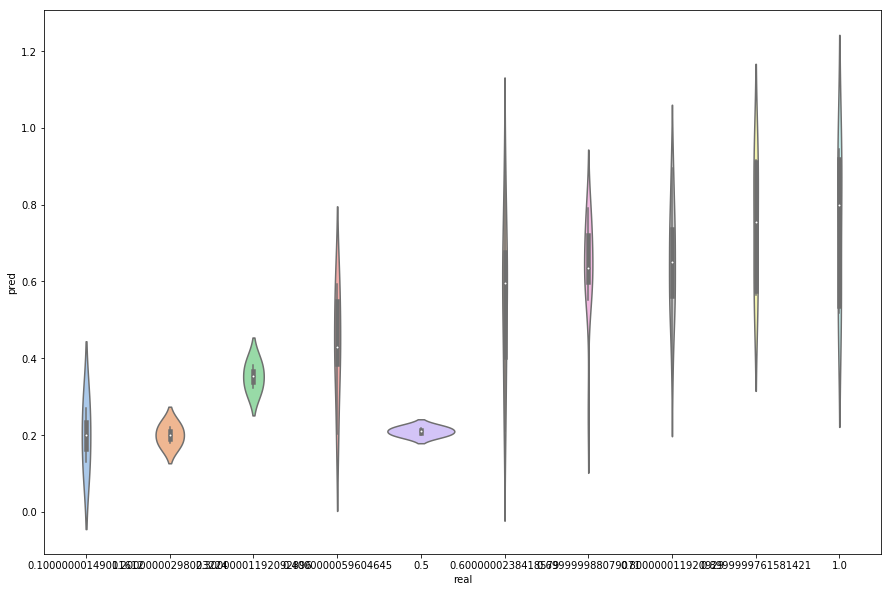

In [70]:
plt.figure(figsize=(15,10))
sns.categorical.violinplot(x="real", y="pred", split=True,  data=pd_df, palette="pastel")


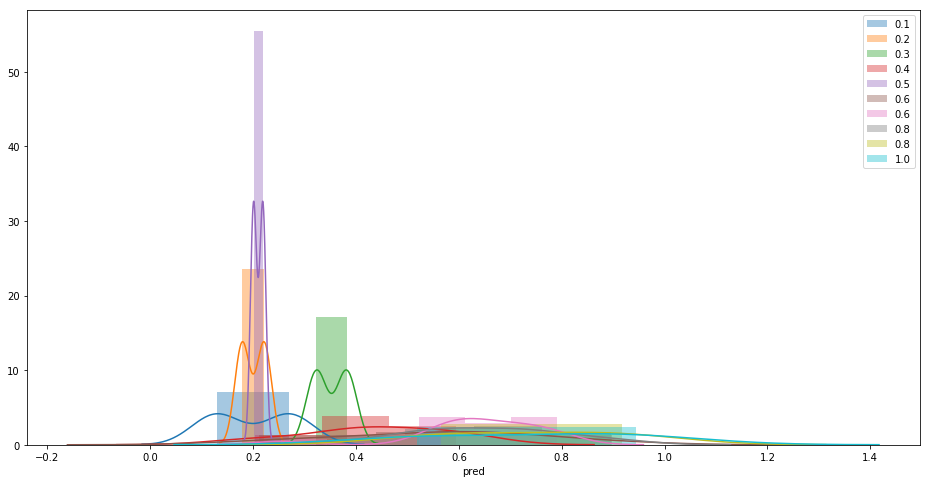

In [71]:
rs = list(pd_df['real'].unique())
rs.sort()
plt.figure(figsize=(16,8))
for r in rs:
    sns.distplot(pd_df['pred'][pd_df['real']==r], label=str(int(r*10)/10))
plt.legend()

In [0]:
Movie_Em = CF.movie_embedding.weight.data.detach().cpu().numpy()

In [0]:
L = np.linalg.norm(Movie_Em,axis=1,keepdims=True)

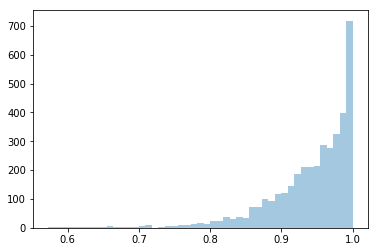

In [74]:
sns.distplot(L,kde=False)

In [0]:
pca = decomposition.PCA(n_components = 5)
M_std = StandardScaler().fit_transform(Movie_Em)
M_pca = pca.fit_transform(M_std)

(-5.93299930719345, 6.940599547028167, -4.352609805960122, 4.770540025687227)

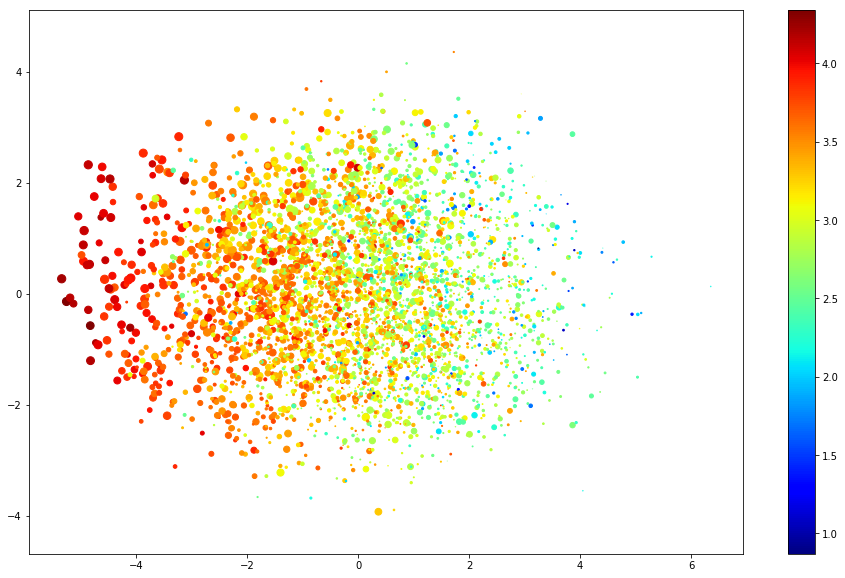

In [0]:
plt.figure(figsize=(16,10))

ss = (movie_df['num_rating'].values - movie_df['num_rating'].min())/60

plt.scatter(M_pca[:,0], M_pca[:,1], c = movie_df['movie_ave_rating'].values, s = ss, cmap='jet')
plt.colorbar()
plt.axis('equal')

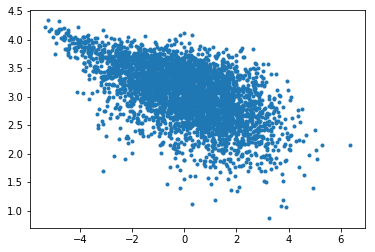

In [0]:
plt.plot(M_pca[:,0], movie_df['movie_ave_rating'],'.')

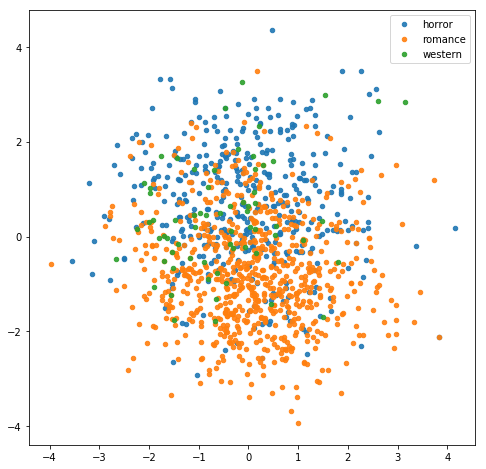

In [0]:
plt.figure(figsize=(8,8))
#for g in ML_Dataset.movie_genres:
for g in ['horror','romance','western']:
    i_g = genres_dict[g]
    ind = np.where(genres[:,i_g]==1)[0].tolist()
    plt.scatter(M_pca[ind,2], M_pca[ind,1],label=g,s=20, alpha=0.9)
plt.legend()

In [0]:
TopMovies_id = movie_df['num_rating'].nlargest(200).index.values

(-3.9317055, 3.2547653)

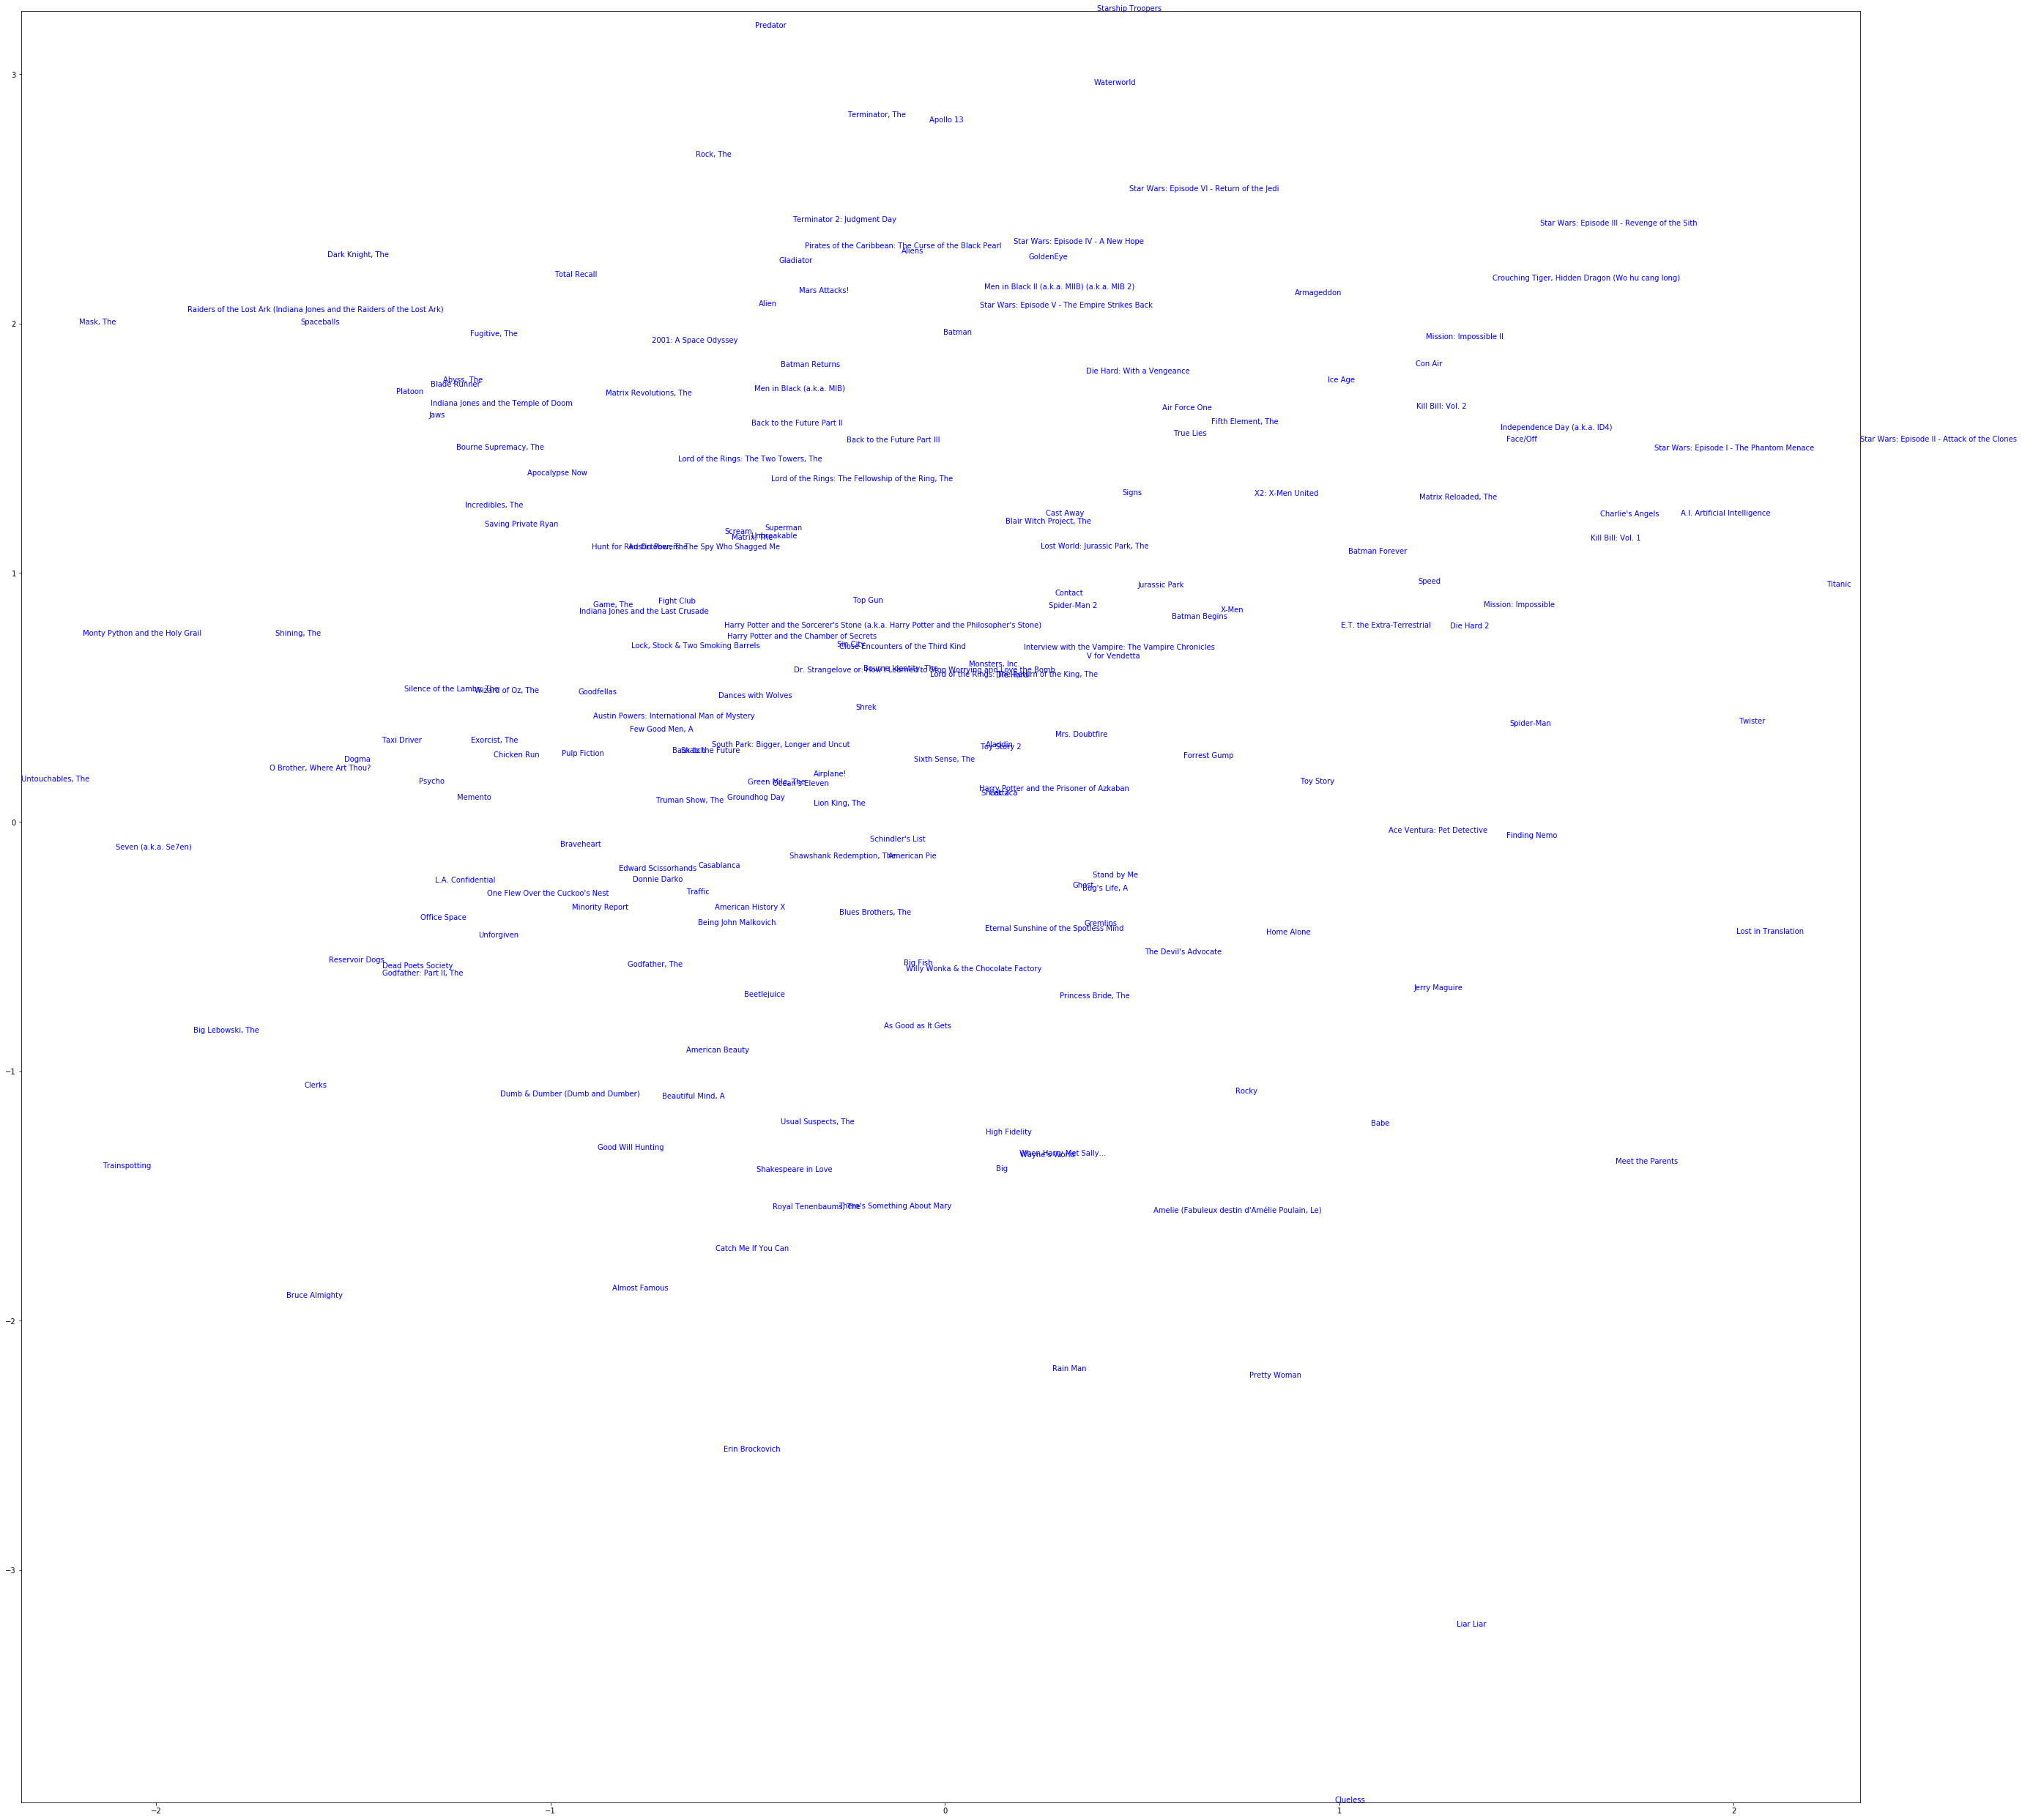

In [0]:
plt.figure(figsize=(45,45))
#plt.scatter(M_pca[:,0], M_pca[:,1])

xs = []
ys = []

for i in TopMovies_id:
    t = movie_df['title'][i]
    x,y = M_pca[i,2], M_pca[i,1]
    xs+=[x]
    ys+=[y]
    #if(x>xlim[0] and x<xlim[1] and y>ylim[0] and y<ylim[1]):
    plt.text(x,y,t,color='b', fontsize=10)

plt.xlim([min(xs),max(xs)])
plt.ylim([min(ys),max(ys)])

In [0]:
Movie_Em = Movie_Em/L
Movie_S = np.matmul(Movie_Em, Movie_Em.T)
for i in range(50):
    movie_id = TopMovies_id[i]
    t = movie_df['title'][movie_id]
    print('Movie:'+t)
    
    tmp_S = Movie_S[movie_id]
    tmp_ids = tmp_S.argsort()[::-1]
    n = 0
    for tmp_id in tmp_ids[1:]:
        if(movie_df['movie_ave_rating'][tmp_id]>0.0):
            t = movie_df['title'][tmp_id]
            print('  ',t)
            n+=1
        if (n>10):
            break
    print()

Movie:Matrix, The
   Superman III
   Matador, The
   Independence Day: Resurgence
   Porky's
   Last Action Hero
   Kill Bill: Vol. 2
   Beavis and Butt-Head Do America
   Analyze That
   Haunting, The
   Bad Words
   Be Cool

Movie:Forrest Gump
   Beavis and Butt-Head Do America
   Be Cool
   Porky's
   Independence Day: Resurgence
   Last Action Hero
   Superman III
   Now You See Me
   Kill Bill: Vol. 2
   Once
   Conan the Destroyer
   Super Mario Bros.

Movie:Back to the Future
   Superman III
   Beavis and Butt-Head Do America
   Super Mario Bros.
   Incredible Hulk, The
   Last Action Hero
   Independence Day: Resurgence
   Porky's
   Indian in the Cupboard, The
   Proof of Life
   Alice Through the Looking Glass
   Now You See Me

Movie:Pulp Fiction
   Kill Bill: Vol. 2
   Last Action Hero
   Matador, The
   Independence Day: Resurgence
   Porky's
   Now You See Me
   Bad Words
   Incredible Hulk, The
   Be Cool
   Shutter
   Superman III

Movie:Jurassic Park
   Last Action Her

In [0]:
movie_embedding = CF.movie_embedding.weight.data.detach().cpu().numpy()
user_embedding = CF.user_embedding.weight.data.detach().cpu().numpy()

In [0]:
genres_weight = CF.genres_layers[0].weight.data.detach().cpu().numpy()
genres_bias = CF.genres_layers[0].bias.data.detach().cpu().numpy()

In [0]:
fc_relevance = [{},{},{}]
for ilayer in range(3):
    fc_relevance[ilayer]['weight'] = CF.fc_layers_relevance[ilayer*2].weight.data.detach().cpu().numpy()
    fc_relevance[ilayer]['bias'] = CF.fc_layers_relevance[ilayer*2].bias.data.detach().cpu().numpy()
    

In [0]:
kw_embedding_np = dict((k,v.detach().cpu().numpy()[0][0]) for (k,v) in kw_embedding.items())

In [0]:
kw_default_embedding.shape

torch.Size([1, 1, 64])

In [0]:
model_weights = {'genres_weight':genres_weight,
                'genres_bias':genres_bias,
                'genres_list': genres_list,
                'genres_dict': genres_dict,
                'movie_embedding': movie_embedding,
                'fc_relevance': fc_relevance,
                 'kw_embedding': kw_embedding_np,
                 'kw_default_embedding': kw_default_embedding[0][0].detach().numpy(),
                 'kw_set': kw_set                 
                }

In [0]:
def get_query_vector(query, model_weights):
    kws = [kw.lower() for kw in query.split(' ')]
    n = 0
    res = np.zeros(64)
    for kw in kws:
        if kw in model_weights['kw_set']:
            print(kw)
            res+=model_weights['kw_embedding'][kw]
            n+=1
    if n==0:
        return model_weights['kw_default_embedding']
    else:
        return res/n

In [0]:
def get_genre_vector(genres, model_weights):
    v = np.zeros((22,1))
    for g in genres:
        if g in model_weights['genres_dict']:
            v[model_weights['genres_dict'][g]]=1
    
    return model_weights['genres_weight'].dot(v).squeeze(1)+model_weights['genres_bias']

In [0]:
def predict(model_weights, query, user_embedding, genres):

    query_embedding = get_query_vector(query, model_weights)
    genres_embedding = get_genre_vector(genres_q, model_weights)

    final_query_em = ave_User_Em + genres_embedding + query_embedding

    relevance_em = np.concatenate((model_weights['movie_embedding'], genres_embedding.reshape(1,64).repeat(nM,axis=0), query_embedding.reshape(1,64).repeat(nM,axis=0)),axis=1)

    for i, fc in enumerate(model_weights['fc_relevance']):
        relevance_em = relevance_em.dot(fc['weight'].T)+fc['bias']
        if i<len(model_weights['fc_relevance'])-1:
            relevance_em = np.tanh(relevance_em)
        else:
            relevance_em = 1. / (1. + np.exp(-relevance_em))

    relevance_score = relevance_em.squeeze(axis=1)
    rating_score = final_query_em.dot(model_weights['movie_embedding'].T).squeeze(0)
    
    return relevance_score, rating_score

In [0]:
query = 'toy story'
genres_q = ['family','animation']

In [0]:
rel, rat = predict(model_weights, query, ave_User_Em, genres_q)

toy
story


In [0]:
ind_rel = np.argsort(rel)[::-1][:200]
ind = [ind_rel[i] for i in np.argsort(rat[ind_rel])[::-1]]

In [0]:
movie_df.iloc[list(ind)]

,index,Unnamed: 0,title,movieId,qmdbId,tmdbId,year,genre_kws,kws_all,num_rating,movie_ave_rating,movie_std_rating
3005,3005,3005,Cats & Dogs: The Revenge of Kitty Galore,8713,3006,39691,2010,"comedy,family",duringcreditsstinger kitty to the cats peyton ...,73,2.061644,1.127144
2906,2906,2906,"Secret of Kells, The",8530,2907,26963,2009,"fantasy,family,animation",animation woman for kells magic beautiful tomm...,272,3.439338,1.019639
1603,1603,1603,Bringing Down the House,4797,1604,10678,2003,comedy,shankman adam down house martin adam escape pr...,603,2.547264,0.909897
3329,3329,3329,Hit and Run (Hit & Run),9283,3330,109513,2012,"action,comedy,romance",dax duringcreditsstinger bell driver kristen a...,113,2.995575,0.846462
1943,1943,1943,"Polar Express, The",6187,1944,5255,2004,"fantasy,adventure,family,animation",robert leslie animation post bibliothek bell s...,1012,2.946146,1.035146
3119,3119,3119,Kung Fu Panda 2,8930,3120,49444,2011,"family,animation",animation woman much yuh jennifer panda black ...,797,3.227102,0.943035
3039,3039,3039,Tangled,8768,3040,38757,2010,"family,animation",runner byron selfishness mother animal chamele...,1198,3.500417,0.917094
3462,3462,3462,Monsters University,9531,3463,62211,2013,"family,animation",animation buscemi dan bd video billy college s...,903,3.329457,0.876356
503,503,503,"Children of Heaven, The (Bacheha-Ye Aseman)",1452,503,21334,1997,"comedy,family,drama",heaven naji majid bacheha ye foot realistic ma...,275,3.812727,1.061272
2038,2038,2038,Be Cool,6777,2039,4551,2005,"crime,comedy",gary don t be a travolta business care music s...,602,2.646179,0.921762
